# Cal Fire Data

In [1]:
import pandas as pd
# I'm using the CSV from their site because for whatever reason, their API leads to 
# a lot more missing data in the latitude and longitude columns. It's full of 0's
fires = pd.read_csv('mapdataall.csv')
pd.set_option('display.max_columns', None)

## Data From Cal Fire, and CSV and API availible at https://www.fire.ca.gov/incidents/

In [2]:
years = [int(y[:4]) for y in fires['incident_date_created'].tolist()]

In [3]:
fires['year'] = years

In [4]:
fires['year'].value_counts()

2017    429
2018    303
2019    263
2020    237
2016    155
2013    141
2015     99
2014     76
1969      2
2009      1
Name: year, dtype: int64

In [5]:
dimensions = fires.shape
print('Number of samples: {}'.format(dimensions[0]))
print('Number of variables: {}'.format(dimensions[1]))
print('Years accounted for: {}'.format(set(years)))

Number of samples: 1706
Number of variables: 24
Years accounted for: {2016, 2017, 2018, 2019, 2020, 1969, 2009, 2013, 2014, 2015}


2009 and 1969 don't look right, lets see how many there are of these years

In [6]:
fires['year'].value_counts()

2017    429
2018    303
2019    263
2020    237
2016    155
2013    141
2015     99
2014     76
1969      2
2009      1
Name: year, dtype: int64

Looks like these are errors, as 2009 and 1996 don't fall in the range of the vast majority of the data.  
Going to remove those points for consistency.

In [7]:
fires = fires[fires['year'] > 2012]

## Quick Look at the Data

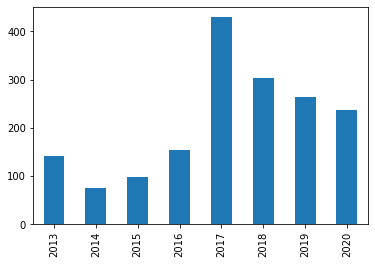

In [8]:
fires['year'].value_counts().sort_index().plot(kind = 'bar')

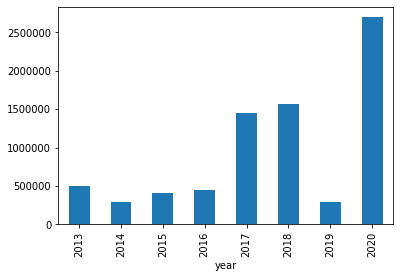

In [9]:
fires.groupby(['year']).sum()['incident_acres_burned'].plot(kind = 'bar')

- 2019 just doesn't look right, there is so little fire compared to the previous and following years. 
- I manually looked at the data and it just seems as if there were no big fires

# Exploring of Variables

In [10]:
print('Number of Samples: {} \nNumber of Variables: {}'.format(fires.shape[0], fires.shape[1]))

Number of Samples: 1703 
Number of Variables: 24


## Going to drop some columns to make visualizing easier.
Reasoning:
- *'incident_administrative_unit_url'* is entirely NA
- *'incident_dateonly_extinguished'* is just 'incident_date_extinguished' but without a time of day
- *'incident_dateonly_created'* is the same as above for 'incident_date_created'  
- *'incident_location'* removed *for now*, they are all unique descriptions of where it is relative to other things, not too uselful when we have latitude and longitude
- *'incident_control'* seems like just assorted notes. Too few fires have data here as well
- *'incident_id'* number seemingly only used when doing lookups on their site.
- *'incident_url'* Just a url to the site
- *'notification_desired'* Only 1 True value, rest are False

In [11]:
fires = fires.drop(['incident_administrative_unit_url','incident_dateonly_extinguished',\
            'incident_dateonly_created','incident_location', 'incident_control',\
           'incident_id','incident_url','notification_desired'], axis = 1)

In [12]:
fires.head(3)

,incident_name,incident_is_final,incident_date_last_update,incident_date_created,incident_administrative_unit,incident_county,incident_acres_burned,incident_containment,incident_cooperating_agencies,incident_longitude,incident_latitude,incident_type,incident_date_extinguished,is_active,calfire_incident,year
0,Bridge Fire,True,2018-01-09 13:46:00,2017-10-31 11:22:00,Shasta-Trinity National Forest,Shasta,37,100,Shasta-Trinity National Forest,-122.309000,40.774000,NaN,2018-01-09 13:46:00,N,False,2017
2,River Fire,True,2013-02-28 20:00:00,2013-02-24 08:16:00,CAL FIRE San Bernardino Unit,Inyo,406,100,"CAL FIRE San Bernardino Unit, Inyo County Sher...",-118.016510,36.602575,NaN,2013-02-28 20:00:00,N,True,2013
3,Fawnskin Fire,True,2013-04-22 09:00:00,2013-04-20 17:30:00,San Bernardino National Forest,San Bernardino,30,100,San Bernardino National Forest,-116.941311,34.288877,NaN,2013-04-22 09:00:00,N,False,2013


In [13]:
print('Number of Samples: {} \nNumber of Variables: {}\n\n'.format(fires.shape[0], fires.shape[1]))
print('   Missingness:')
fires.isna().sum(axis = 0)

Number of Samples: 1703 
Number of Variables: 16


   Missingness:


incident_name                       0
incident_is_final                   0
incident_date_last_update           0
incident_date_created               0
incident_administrative_unit        9
incident_county                    11
incident_acres_burned               0
incident_containment                0
incident_cooperating_agencies     229
incident_longitude                  0
incident_latitude                   0
incident_type                    1218
incident_date_extinguished        130
is_active                           0
calfire_incident                    0
year                                0
dtype: int64

# Missing Data
- Exploring where the 'acres burned' is missing
    - Mostly in 2020, but a strangely large amount in 2017
    - I believe it's just because there is a lot of data for 2017, so naturally a proportional amount is missing

In [14]:
# shows the number of missing (zero acre fires) in the data for each year
(fires[fires['incident_acres_burned']==0])['year'].value_counts()

2020    31
2017    14
2016     4
2019     2
2018     2
2013     2
2015     1
2014     1
Name: year, dtype: int64

In [15]:
missing_burns = fires[fires['incident_acres_burned']==0]
missing_burns[missing_burns['is_active'] == 'Y']['year'].value_counts()

2020    16
Name: year, dtype: int64

- Shows that most of the missing 2020 data is because the fire is still going

Below shows the top 100 fires by acres burned. It seems like 2019 just didn't have mnay big fires, whereas all the other years did

In [16]:
fires[['incident_name','incident_acres_burned','year']]\
.sort_values('incident_acres_burned', ascending = False)\
.reset_index(drop = True).iloc[:100]['year'].value_counts()

2017    29
2018    17
2020    16
2013    10
2016     8
2019     7
2015     7
2014     6
Name: year, dtype: int64

## What's happening in 2019?
This graph is similar to the bar graph, but allows every point to be seen, organized by days since records started
- This allows it to continue to be chronological
* Pandas has issues sorting by date so this was needed
- Helps show that there wasn't a lack of data in the 2019 range, but just a lack of large fires

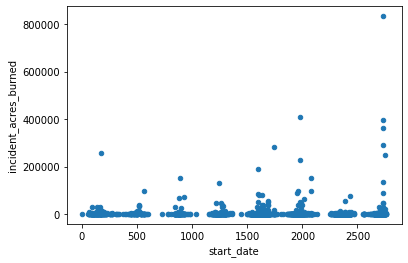

In [17]:
fires.loc[:,'start_date'] = pd.to_datetime(fires['incident_date_created'])-pd.to_datetime(fires['incident_date_created']).min()
fires.loc[:,'start_date'] = fires['start_date'].apply(lambda x: x.days)
fires[['start_date', 'incident_acres_burned']].plot(kind = 'scatter', x = 'start_date', y= 'incident_acres_burned')

There are holes though, and consistently through the data. I imagine this is because of winter/spring where fires would be harder to start, but lets see

In [18]:
fires['month'] = [int(y[5:7]) for y in fires['incident_date_created'].tolist()]
monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

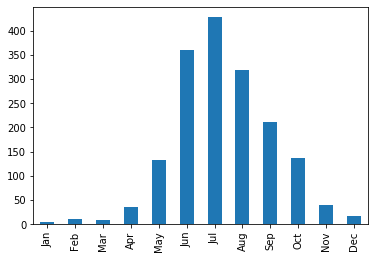

In [19]:
pd.Series(data = fires['month'].value_counts(sort = False).to_list(), index = monthDict.values()).plot(kind = 'bar')

### Holes in data?
The holes make sense, and they are just as I expected
- Frome November to April, there are basically no fires.
- This explains the seemingly empty spots in the graph before this one 
- There just aren't really any fires in winter or spring

## Missing Data Conclusion
- Seems like it just be that 2019 didn't have many big fires
    - Since there is a consistent *amount* of samples in that time, it doesn't seem like the lack of large fires is due to missingness
    - Because of this I don't think I should do any data imputation
- The holes in the data can be explained, there just aren't really fires in the spring/winter
    - Pretty interesting how the data is actually pretty normalized  

<br>
<br>
<b>Another interesting point:</b>  <br>
I tried using both the downloadable CSV from the CalFires page, and also the API, but...

This basically shows the missingness of the coordinates of the fires. Given that there are no NAN values, and they are basically all unique, it doesn't seem like there is any missing data. **CSV has no missing coordinate data**

In [20]:
fires['incident_longitude'].value_counts()

-118.551000    2
-116.866300    2
-120.553075    2
-120.005210    2
-122.527500    2
              ..
-121.786770    1
-120.452330    1
-120.452041    1
-118.704430    1
-122.000000    1
Name: incident_longitude, Length: 1689, dtype: int64

**Meanwhile** with the json file from the API, we see that 804 of the 1695 data points are all 0 (at least when I am checking) so **half of the JSON coordinate data is missing**

In [21]:
api_data = pd.read_json('https://www.fire.ca.gov/umbraco/api/IncidentApi/List?inactive=true')
api_data['Longitude'].value_counts()

 0.000000      804
-120.005210      2
-120.553075      2
-119.643000      2
-116.941311      2
              ... 
-120.876090      1
-119.949740      1
-122.851940      1
-116.806941      1
-122.267360      1
Name: Longitude, Length: 1695, dtype: int64